In [1]:
import sys
print(f'Working with Python {sys.version}')

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import pymzml
import numpy as np
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import fiora.IO.mspReader as mspReader
import fiora.IO.mgfReader as mgfReader
import fiora.visualization.spectrum_visualizer as sv


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


In [2]:
path: str = f"{home}/data/metabolites/MSnLib/" 

dfs = []
for filename in os.listdir(path):
    if filename.endswith("MS2.mgf"):
        filepath = path + filename
        print(f"Reading {filename}")
        df = pd.DataFrame(mgfReader.read(path + filename))
        df["file"] = filename
        df["lib"] = "MSnLib"
        df["origin"] = filename.split("_")[1]
        df["Collision energy"] = df["Collision energy"].astype(float)
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True)

Reading 20240411_mcebio_library_pos_all_lib_MS2.mgf
Reading 20231031_nihnp_library_neg_all_lib_MS2.mgf
Reading 20231130_otavapep_library_pos_all_lib_MS2.mgf
Reading 20231130_mcescaf_library_pos_all_lib_MS2.mgf
Reading 20231031_nihnp_library_pos_all_lib_MS2.mgf
Reading 20231130_otavapep_library_neg_all_lib_MS2.mgf
Reading 20231130_mcescaf_library_neg_all_lib_MS2.mgf
Reading 20240411_mcebio_library_neg_all_lib_MS2.mgf


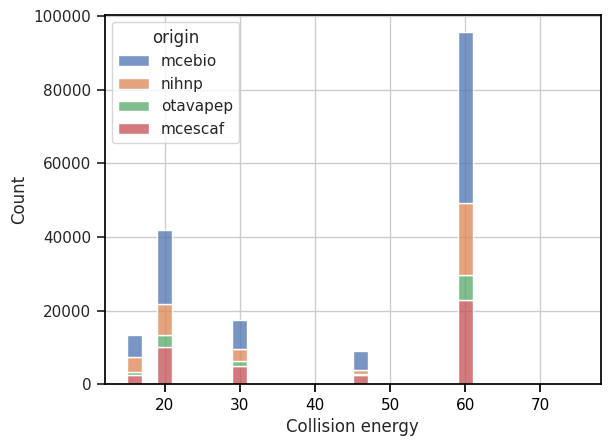

In [3]:
from fiora.visualization.define_colors import *
set_light_theme()
sns.histplot(data=df, x="Collision energy", hue="origin", multiple="stack", binwidth=2)
plt.show()


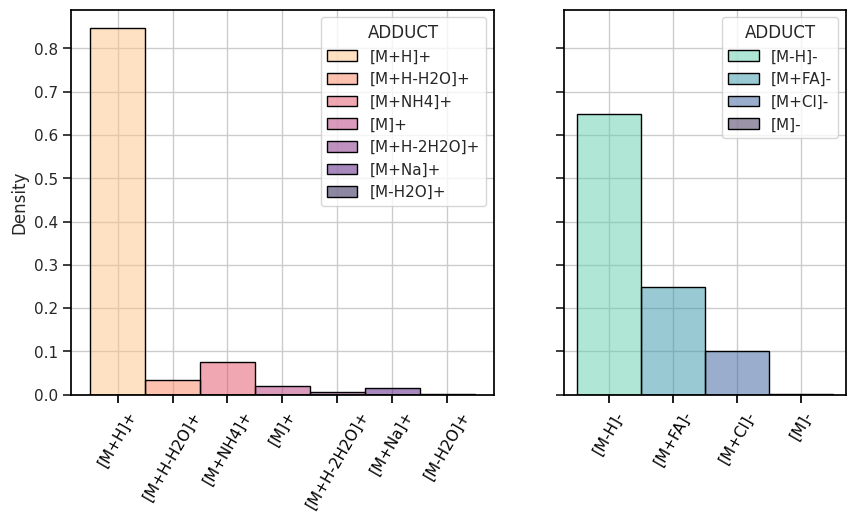

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.5, 1]}, sharey=True)
#plt.subplots_adjust(wspace=0.1, hspace=0.05)

sns.histplot(ax=axs[0], data=df[df["IONMODE"] == "Positive"], x="ADDUCT", palette=magma(7), hue="ADDUCT", edgecolor="black", stat="density")
axs[0].tick_params(axis='x', rotation=60)
axs[0].set_xlabel("")
sns.histplot(ax=axs[1], data=df[df["IONMODE"] == "Negative"], x="ADDUCT", palette=sns.color_palette("mako_r", 4), hue="ADDUCT", edgecolor="black", stat="density")
axs[1].set_xlabel("")
axs[1].tick_params(axis='x', rotation=60)
plt.show()

In [5]:
from fiora.MOL.Metabolite import Metabolite
from fiora.MOL.constants import PPM
TOLERANCE = 10 * PPM




In [6]:
df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df["Metabolite"].apply(lambda x: x.compute_graph_attributes())
df["Metabolite"].apply(lambda x: x.fragment_MOL())
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
177385    None
177386    None
177387    None
177388    None
177389    None
Length: 177390, dtype: object

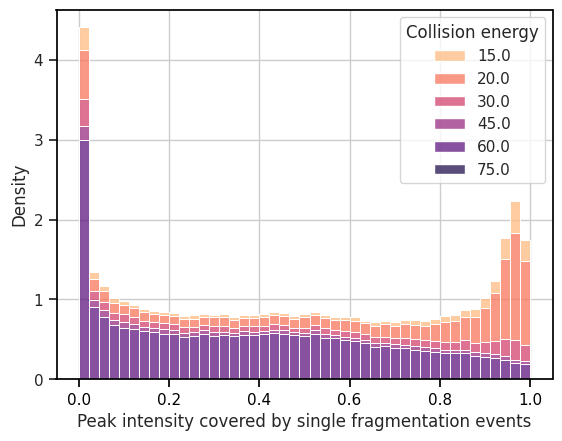

In [7]:
df["coverage"] = df["Metabolite"].apply(lambda x: x.match_stats["coverage"])
sns.histplot(df, x="coverage", hue="Collision energy", palette=magma(6), multiple="stack", stat="density")
plt.xlabel("Peak intensity covered by single fragmentation events")
plt.show()

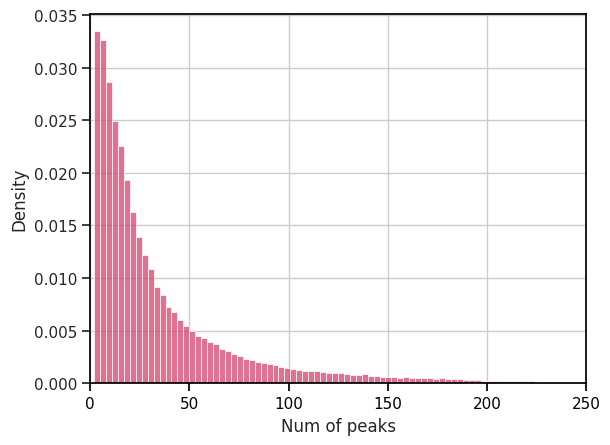

In [8]:
df["Num peaks"] = df["Num peaks"].astype(int)
sns.histplot(df, x="Num peaks",  color=magma(6)[2], multiple="stack", stat="density", binwidth=3, edgecolor="white", linewidth=0.5)
plt.xlabel("Num of peaks")
plt.xlim(0,250)
plt.show()

In [9]:
print("Assign unique metabolite identifiers.")
print("Unique smiles: " + str(len(df["SMILES"].unique())))

metabolite_id_map = {}
for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.set_id(id)
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite

df["group_id"] = df["Metabolite"].apply(lambda x: x.get_id())
df["num_per_group"] = df["group_id"].map(df["group_id"].value_counts())

for i, data in df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

def print_df_stats(df):
    num_spectra = df.shape[0]
    num_ids = len(df["group_id"].unique())
    
    print(f"Dataframe stats: {num_spectra} spectra covering {num_ids} unique structures")

print_df_stats(df)

Assign unique metabolite identifiers.
Unique smiles: 16392
Found 15967 unique molecular structures.
Dataframe stats: 177390 spectra covering 15967 unique structures


### Begin filtering

In [10]:
df.columns

Index(['index', 'NAME', 'COMMENT', 'DESCRIPTION', 'EXACTMASS', 'FORMULA',
       'INCHI', 'INCHIAUX', 'SMILES', 'FEATURE_ID', 'MSLEVEL', 'RTINSECONDS',
       'ADDUCT', 'PEPMASS', 'CHARGE', 'SPECTYPE', 'Collision energy',
       'FRAGMENTATION_METHOD', 'ISOLATION_WINDOW', 'Acquisition',
       'INSTRUMENT_TYPE', 'SOURCE_INSTRUMENT', 'IMS_TYPE', 'ION_SOURCE',
       'IONMODE', 'PI', 'DATACOLLECTOR', 'DATASET_ID', 'USI', 'SCANS',
       'PRECURSOR_PURITY', 'QUALITY_CHIMERIC', 'QUALITY_EXPLAINED_INTENSITY',
       'QUALITY_EXPLAINED_SIGNALS', 'Num peaks', 'peaks',
       'OTHER_MATCHED_COMPOUNDS', 'OTHER_MATCHED_COMPOUNDS_NAMES', 'file',
       'lib', 'origin', 'Metabolite', 'coverage', 'group_id', 'num_per_group'],
      dtype='object')

In [11]:
cast_float = ["PEPMASS", "RTINSECONDS", "Collision energy"]
df[cast_float] = df[cast_float].astype(float)
df["ionization"] = "ESI"
df["instrument"] = "HCD"

In [12]:
# TODO HERE #%%capture
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

metadata_key_map = {
                "name": "NAME",
                "collision_energy":  "Collision energy", 
                "instrument": "instrument",
                "ionization": "ionization",
                "precursor_mz": "PEPMASS",
                "precursor_mode": "ADDUCT",
                "retention_time": "RTINSECONDS",
                }

filter_spectra = True
CE_upper_limit = 100.0
weight_upper_limit = 1000.0
allowed_precursor_modes = ["[M+H]+", "[M-H]-", "[M]+", "[M]-"] # TODO add "[M]+" and [M]-


node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

if filter_spectra:
    df = df[df['ADDUCT'].isin(allowed_precursor_modes)]
    num_ori = df.shape[0]
    correct_energy = df["Metabolite"].apply(lambda x: x.metadata["collision_energy"] <= CE_upper_limit and x.metadata["collision_energy"] > 1) 
    df = df[correct_energy]
    correct_weight = df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"] <= weight_upper_limit)
    df = df[correct_weight]    
    print(f"Filtering spectra ({num_ori}) down to {df.shape[0]}")
    #print(df["Precursor_type"].value_counts())


Filtering spectra (137199) down to 136133


In [13]:
#
# IMPORTANT: FILTER AND CLEAN DATA
#

drop_index = []
for i,d in df.iterrows():
    M = d["Metabolite"]

    min_coverage = 0.5
    if M.match_stats["coverage"] < min_coverage: # Filter if total coverage is too low
        drop_index.append(i)
    
    min_peaks = 2
    if M.match_stats["num_peak_matches_filtered"] < min_peaks:
        drop_index.append(i)

    # Either condition is enough to keep the spectrum
    desired_peaks = 5
    desired_peak_percentage = 0.5
    extremly_high_coverage = 0.8
    if (M.match_stats["num_peak_matches_filtered"] < desired_peaks) & (M.match_stats["percent_peak_matches_filtered"] < desired_peak_percentage) & (M.match_stats["coverage"] < extremly_high_coverage):
        drop_index.append(i)

    #if M.match_stats["num_non_precursor_matches"] < 1:
    #    drop_index.append(i)
    # max_conflicts_rel = 0.75
    # if M.match_stats["rel_fragment_conflicts"] > max_conflicts_rel: 
    #     drop_index.append(i)
    
    max_precursor = 0.9
    if M.match_stats["precursor_prob"] > max_precursor: # Filter if fragment coverage is too low (intensity wise)
       drop_index.append(i)

In [14]:
print_df_stats(df)
drop_index = np.unique(drop_index)
print(f"Filtering out {len(drop_index)} that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible")
df = df.drop(drop_index)
print_df_stats(df)

Dataframe stats: 136133 spectra covering 14808 unique structures
Filtering out 82375 that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible
Dataframe stats: 53758 spectra covering 10341 unique structures


### Align train/test sets with other datasets

<Axes: xlabel='coverage', ylabel='Count'>

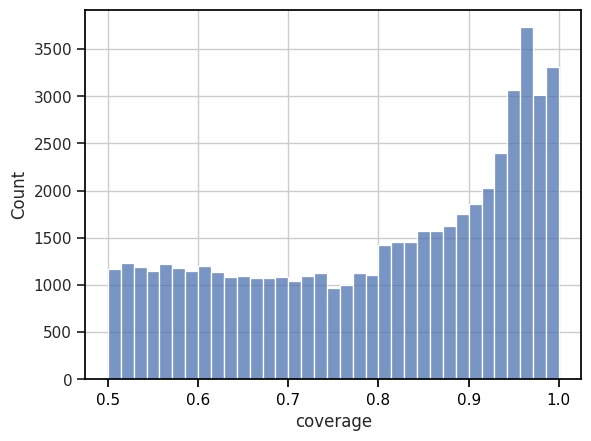

In [15]:
sns.histplot(df, x= "coverage")

In [16]:
from fiora.IO.LibraryLoader import LibraryLoader


train_ids, va_ids, test_ids = [], [], []

L = LibraryLoader()
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"
df_merged = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)
df_cast = pd.read_csv(f"{home}/data/metabolites/CASMI_2016/casmi16t_withCCS.csv", index_col=[0], low_memory=False)

other_dfs = {
    "train": df_merged[df_merged["dataset"] == "training"].drop_duplicates(subset=["group_id"]),
    "val": df_merged[df_merged["dataset"] == "validation"].drop_duplicates(subset=["group_id"]),
    "test": pd.concat([df_merged[df_merged["dataset"] == "test"].drop_duplicates(subset=["group_id"]), df_cas, df_cast, df_cas22]).drop_duplicates(subset=["SMILES"]),
}

In [19]:
lookup_table = {
    "train": set(),
    "val": set(),
    "test": set()
}
for key, df_x in other_dfs.items():
     df_x["Metabolite"] = df_x["SMILES"].apply(Metabolite)
     
     for i, data in df_x.iterrows():
         lookup_table[key].add((data["Metabolite"].ExactMolWeight, data["Metabolite"].morganFingerCountOnes))
     

In [23]:
train, val, test = [], [], []


for id in df["group_id"].unique():
    metabolite: Metabolite = df[df["group_id"] == id].iloc[0]["Metabolite"]
    fast_identifiers = (metabolite.ExactMolWeight, metabolite.morganFingerCountOnes)
    found_match = False
    
    if fast_identifiers in lookup_table["train"]:
        for i, data in other_dfs["train"].iterrows():
            other_metabolite = data["Metabolite"]
            if metabolite == other_metabolite:
                train.append(id)
                found_match = True
                break
    if not found_match and fast_identifiers in lookup_table["val"]:
        for i, data in other_dfs["val"].iterrows():
            other_metabolite = data["Metabolite"]
            if metabolite == other_metabolite:
                val.append(id)
                break
    if not found_match and fast_identifiers in lookup_table["test"]:
            for i, data in other_dfs["test"].iterrows():
                other_metabolite = data["Metabolite"]
                if metabolite == other_metabolite:
                    test.append(id)
                    break

In [28]:
print(f"{len(train)=} {len(val)=} {len(test)=}")
print(f"{train[:5]=} {val[-5:]=} {test[5:10]=}")

len(train)=1091 len(val)=121 len(test)=198
train[:5]=[12, 23, 34, 50, 82] val[-5:]=[5712, 15844, 6044, 15888, 6413] test[5:10]=[733, 748, 830, 947, 987]


In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=seed):
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys


group_ids = df["group_id"].astype(int)
keys = np.unique(group_ids)
# TODO align test keys with other datasets


for i in range(100):
    train, val, test = train_val_test_split(keys, rseed=seed + i)

df["dataset"] = df["group_id"].apply(lambda x: 'train' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')


### Save datasplits and metadata

In [ ]:
from modules.MOL.constants import ADDUCT_WEIGHTS, PPM

df["Precursor_offset"] = df["PRECURSORMZ"] - df.apply(lambda x: x["Metabolite"].ExactMolWeight + ADDUCT_WEIGHTS[x["PRECURSORTYPE"]], axis=1)
df["Precursor_abs_error"] = abs(df["Precursor_offset"])
df["Precursor_rel_error"] = df["Precursor_abs_error"] / df["PRECURSORMZ"]
df["Precursor_ppm_error"] = df["Precursor_abs_error"] / (df["PRECURSORMZ"] * PPM)
print((df["Precursor_ppm_error"] > 500).sum())
d = df[df["Precursor_ppm_error"] > 500].iloc[0]
print(d["Metabolite"].ExactMolWeight)
print(d["Metabolite"])
df["SMILES"].apply(lambda x: "+" in x).sum()

ModuleNotFoundError: No module named 'modules'

In [ ]:
%%capture
from modules.MOL.Metabolite import Metabolite
from modules.MOL.constants import PPM
TOLERANCE = 200 * PPM


df["Metabolite"] = df["SMILES"].apply(Metabolite)
df = df[df["Metabolite"].apply(lambda x: x.is_single_connected_structure())]
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df["Metabolite"].apply(lambda x: x.compute_graph_attributes())
df["Metabolite"].apply(lambda x: x.fragment_MOL())
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)

In [ ]:
# for i, d in df.iterrows():
#     fragments = Chem.GetMolFrags(d["Metabolite"].MOL, asMols=True)
#     if len(fragments) == 1:
#         d["Metabolite"].fragment_MOL()
#     else: 
#         try:
#             d["Metabolite"].fragment_MOL()
#             print("Unexpected")
#             print(i, d)
#         except:
#             print("Expected")


In [ ]:
# Define figure styles
color_palette = sns.color_palette("magma_r", 8)
sns.set_theme(style="whitegrid",
                  rc={'axes.edgecolor': 'black', 'ytick.left': True, 'xtick.bottom': True, 'xtick.color': 'black',
                      "axes.spines.bottom": True, "axes.spines.right": True, "axes.spines.top": True,
                      "axes.spines.left": True})

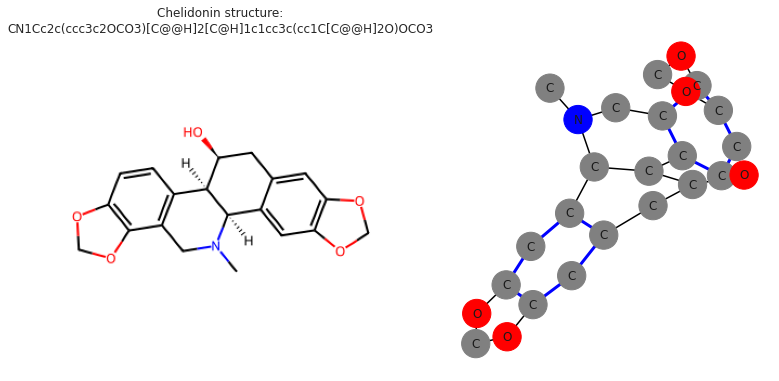

{'mz': [135.044, 247.075, 265.085, 275.069, 276.072, 277.076, 293.08, 295.095, 296.098, 303.064, 305.079, 306.083, 307.089, 323.09, 324.093, 325.096, 334.106, 336.121, 337.124, 352.116, 353.119, 354.132, 355.135, 356.137], 'intensity': [10.0, 46.0, 11.0, 489.0, 87.0, 10.0, 19.0, 71.0, 12.0, 15.0, 394.0, 76.0, 14.0, 368.0, 69.0, 10.0, 10.0, 81.0, 17.0, 51.0, 12.0, 1000.0, 208.0, 27.0], 'annotation': []}


In [ ]:
from modules.MOL.mol_graph import draw_graph
x = df.iloc[0]
x_mol = x["Metabolite"].MOL
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)

img = Chem.Draw.MolToImage(x_mol, ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(x["NAME"]+ " structure:\n" + Chem.MolToSmiles(x_mol))
axs[0].imshow(img)
axs[0].axis("off")

g_img = draw_graph(x["Metabolite"].Graph, ax=axs[1])
print(x["peaks"])

In [ ]:
from modules.MOL.constants import DEFAULT_MODES
df["peak_matches"] = df["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
df["num_peaks_matched"] = df["peak_matches"].apply(len)

def get_match_stats(matches, mode_count={m: 0 for m in DEFAULT_MODES}):
    num_unique, num_conflicts = 0, 0
    for mz, match_data in matches.items():
        #candidates = match_data["fragments"]
        ion_modes = match_data["ion_modes"]
        if len(ion_modes) == 1:
            num_unique += 1
        elif len(ion_modes) > 1:
            num_conflicts += 1
        for c in ion_modes:
            mode_count[c[0]] += 1
    return num_unique, num_conflicts, mode_count



df["match_stats"] = df["peak_matches"].apply(lambda x: get_match_stats(x))
df["num_unique_peaks_matched"] = df.apply(lambda x: x["match_stats"][0], axis=1)
df["num_conflicts_in_peak_matching"] = df.apply(lambda x: x["match_stats"][1], axis=1)
df["match_mode_counts"] = df.apply(lambda x: x["match_stats"][2], axis=1)
u= df["num_unique_peaks_matched"].sum() 
s= df["num_conflicts_in_peak_matching"].sum() 
print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
print(f"Total number of conflicting peak to fragment matches: {s}")

/tmp/ipykernel_851052/463457465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["peak_matches"] = df["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
/tmp/ipykernel_851052/463457465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_peaks_matched"] = df["peak_matches"].apply(len)
/tmp/ipykernel_851052/463457465.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Total number of uniquely matched peaks: 527811 , conflicts found within 97672 matches (15.62 %))
Total number of conflicting peak to fragment matches: 97672


/tmp/ipykernel_851052/463457465.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["match_mode_counts"] = df.apply(lambda x: x["match_stats"][2], axis=1)


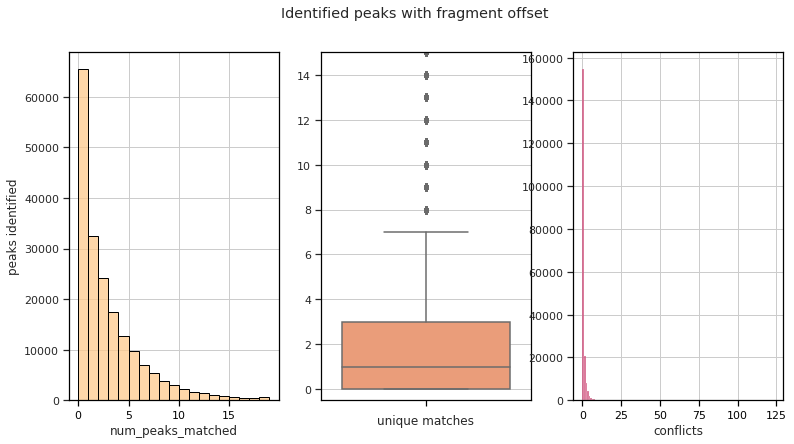

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12.8, 6.4), sharey=False)

fig.suptitle(f"Identified peaks with fragment offset")
#plt.title(f"Identified peaks with fragment offset: {str(off)}")
sns.histplot(ax=axs[0],data=df, x="num_peaks_matched", color=color_palette[0], edgecolor="black", bins=range(0,20, 1))
#axs[0].set_ylim(-0.5, 10)
axs[0].set_ylabel("peaks identified")


sns.boxplot(ax=axs[1],data=df, y="num_unique_peaks_matched", color=color_palette[1])
axs[1].set_ylim(-0.5, 15)
axs[1].set_xlabel("unique matches")
axs[1].set_ylabel("")


sns.histplot(ax=axs[2],data=df, x="num_conflicts_in_peak_matching", color=color_palette[3], binwidth=1)
#axs[2].set_ylim(-0.5, 1000)
axs[2].set_xlabel("conflicts")
axs[2].set_ylabel("")

plt.show()

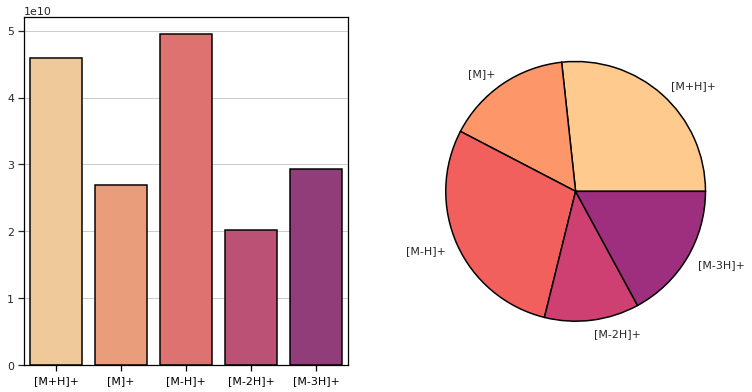

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

mode_counts = {m: 0 for m in DEFAULT_MODES}

def update_mode_counts(m):
    for mode in m.keys():
        mode_counts[mode] += m[mode]

df["match_mode_counts"].apply(update_mode_counts)

sns.barplot(ax=axs[0], x=list(mode_counts.keys()), y=[mode_counts[k] for k in mode_counts.keys()], palette=color_palette, edgecolor="black", linewidth=1.5)
axs[1].pie([mode_counts[k] for k in mode_counts.keys()], labels=list(mode_counts.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5})

plt.show()

In [ ]:
# Add is in CASMI 2016 Info
import pandas as pd
from modules.MOL.Metabolite import Metabolite

casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_challenges_combined.csv"
df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df.dropna(subset=["SMILES"], inplace=True)
df["in_casmi2016"] = False

for i,d in df_cas.iterrows():
    m = d["Metabolite"]
    
    for x,D in df.iterrows():
        M = D["Metabolite"]
        if (m == M):
            df.at[x, "in_casmi2016"] = True
del df_cas

/tmp/ipykernel_851052/2616585280.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["SMILES"], inplace=True)
/tmp/ipykernel_851052/2616585280.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["in_casmi2016"] = False


In [ ]:

for i in range(0,6):
    print(f"Minimum {i} unique peaks identified (including precursors): ", (df["num_unique_peaks_matched"] >= i).sum())


Minimum 0 unique peaks identified (including precursors):  193438
Minimum 1 unique peaks identified (including precursors):  123776
Minimum 2 unique peaks identified (including precursors):  86279
Minimum 3 unique peaks identified (including precursors):  61859
Minimum 4 unique peaks identified (including precursors):  45159
Minimum 5 unique peaks identified (including precursors):  33576


In [ ]:
# raise KeyboardInterrupt()

In [ ]:
df[(df["CE"] < 1)]["COLLISIONENERGY"]

1749        0
1752        0
1755        0
1758        0
1761        0
         ... 
186050    -20
186063    -20
186065    -12
186083    -35
186086    -14
Name: COLLISIONENERGY, Length: 344, dtype: object

In [ ]:
df[(df["CE"] < 1)]["COLLISIONENERGY"]

1749        0
1752        0
1755        0
1758        0
1761        0
         ... 
186050    -20
186063    -20
186065    -12
186083    -35
186086    -14
Name: COLLISIONENERGY, Length: 344, dtype: object

In [ ]:
raise KeyboardInterrupt()

In [ ]:
save_df = False
lib = f"{home}/data/metabolites/MS_DIAL/"
name = "ms_dial_filtered"
date = "XXX" # "mid_08_2023" #"mid_08_2023" #"07_2023"
min_peaks = 5

if save_df:
       file = lib + name + "_min" + str(min_peaks) + "_" + date + ".csv"
       print("saving to ", file)
       df[df["num_unique_peaks_matched"] >= min_peaks].to_csv(file)
       
       #df.to_csv(lib + name + "_all" + "_" + date + ".csv") #TODO HERE

saving to  /home/ynowatzk/data/metabolites/MS_DIAL/ms_dial_filtered_min5_mid_08_2023.csv


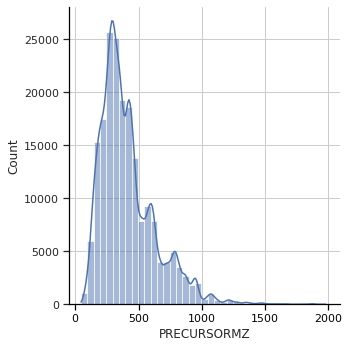

In [ ]:
sns.displot(df, x="PRECURSORMZ", kde=True, binwidth=50)
plt.show()

/tmp/ipykernel_851052/1632106418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)


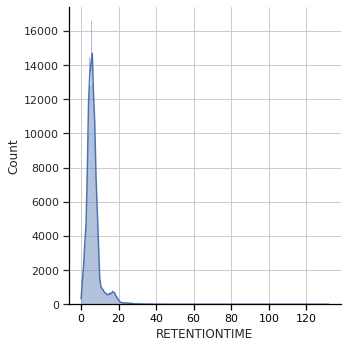

In [ ]:
df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)
sns.displot(df, x="RETENTIONTIME", kde=True, binwidth=0.5)
plt.show()

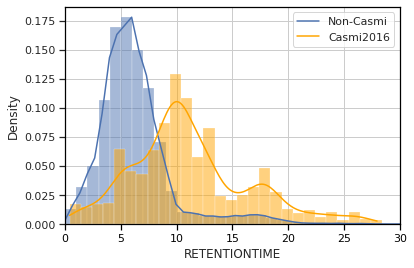

In [ ]:

sns.histplot(df[~df["in_casmi2016"]], x="RETENTIONTIME", kde=True, binwidth=1, stat="density", multiple="stack")
sns.histplot(df[df["in_casmi2016"]], x="RETENTIONTIME", kde=True, binwidth=1, stat="density", multiple="stack", color="orange")
plt.legend(labels=["Non-Casmi", "Casmi2016"])
plt.xlim([0,30])
plt.show()

/tmp/ipykernel_851052/2201103238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CCS"] = df["CCS"].astype(float)


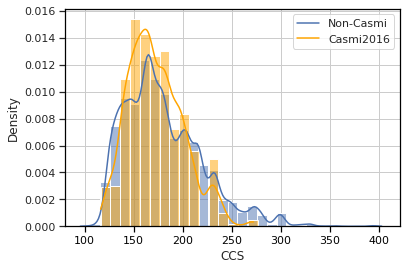

In [ ]:
df["CCS"] = df["CCS"].astype(float)
sns.histplot(df[~df["in_casmi2016"]], x="CCS", kde=True, binwidth=10, stat="density", multiple="stack")
sns.histplot(df[df["in_casmi2016"]], x="CCS", kde=True, binwidth=10, stat="density", multiple="stack", color="orange")
plt.legend(labels=["Non-Casmi", "Casmi2016"])

plt.show()

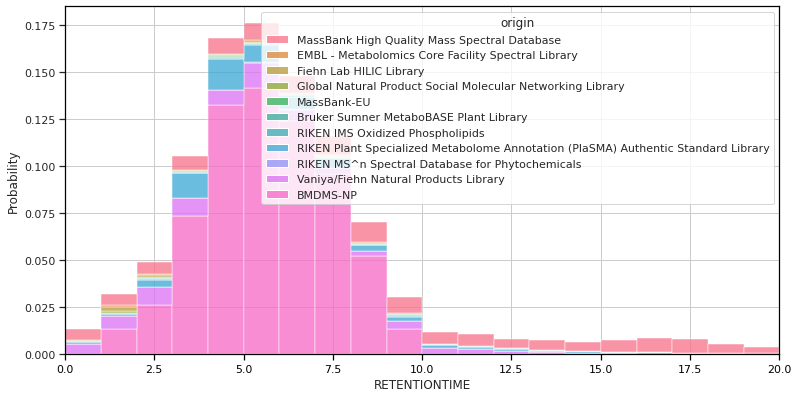

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.histplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="stack", binwidth=1, stat="probability")
plt.xlim([0, 20])
plt.show()

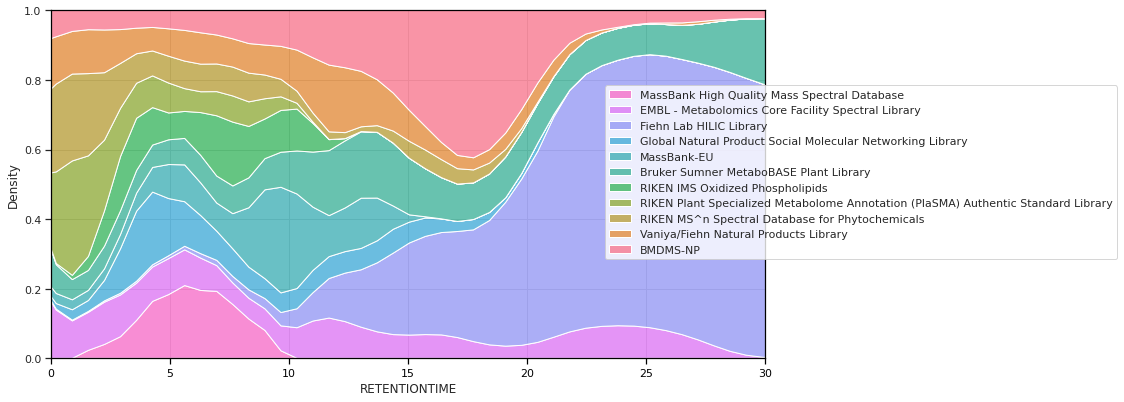

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="fill", common_norm=False)
ax.legend(bbox_to_anchor=(1.5, 0.8), labels=df["origin"].unique())
plt.xlim([0, 30])
plt.show()
    
    

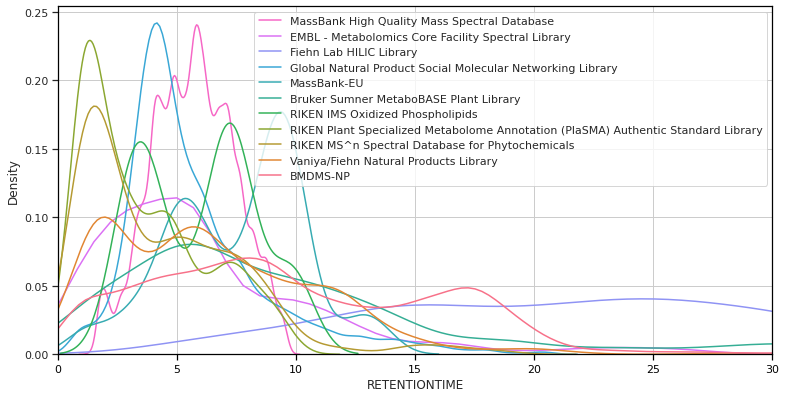

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="layer", common_norm=False)
plt.legend(labels=df["origin"].unique())
plt.xlim([0, 30])
plt.show()

In [ ]:
df["origin"].value_counts()

BMDMS-NP                                                                             112495
Vaniya/Fiehn Natural Products Library                                                 29669
MassBank High Quality Mass Spectral Database                                          28151
RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library     11587
RIKEN MS^n Spectral Database for Phytochemicals                                        6695
Bruker Sumner MetaboBASE Plant Library                                                 1532
Fiehn Lab HILIC Library                                                                1019
EMBL - Metabolomics Core Facility Spectral Library                                     1013
Global Natural Product Social Molecular Networking Library                              727
RIKEN IMS Oxidized Phospholipids                                                        386
MassBank-EU                                                                     

In [ ]:
print(len(df["SMILES"].unique()))
print(len(df[df["origin"] == "BMDMS-NP"]["SMILES"].unique()))

13748
2493


<AxesSubplot: xlabel='SMILES', ylabel='Count'>

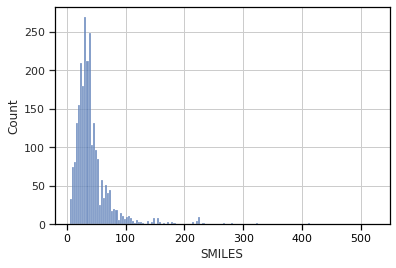

In [ ]:
sns.histplot(df[df["origin"] == "BMDMS-NP"]["SMILES"].value_counts())

<AxesSubplot: xlabel='SMILES', ylabel='Count'>

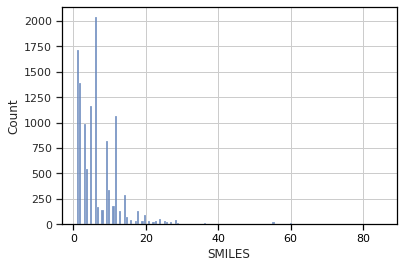

In [ ]:
sns.histplot(df[df["origin"] != "BMDMS-NP"]["SMILES"].value_counts())

<AxesSubplot: xlabel='origin', ylabel='Count'>

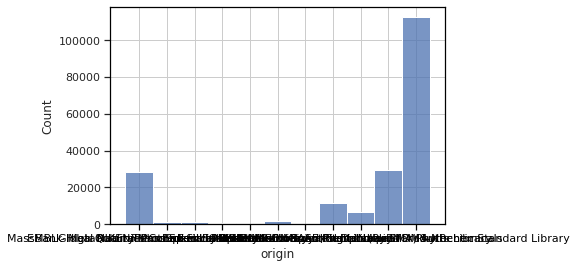

In [ ]:
#sns.catplot(data=df, x="origin")
sns.histplot(data=df, x="origin")

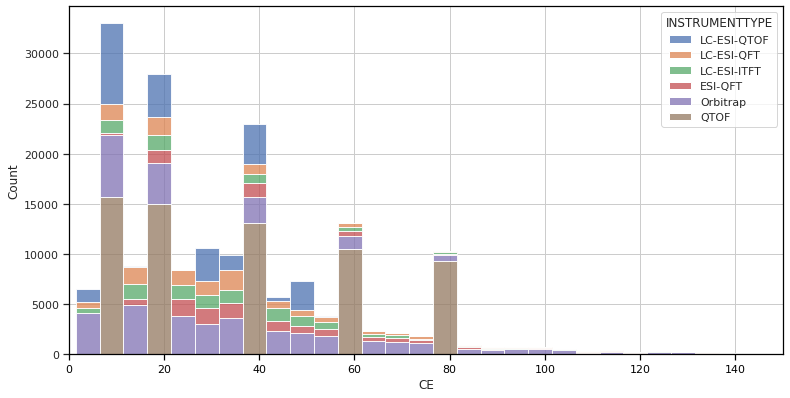

(193438, 28)


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12.8, 6.4), sharey=False)


top_instrumenttypes = df['INSTRUMENTTYPE'].value_counts().head(6).index
sns.histplot(data=df[df['INSTRUMENTTYPE'].isin(top_instrumenttypes)], x="CE", hue="INSTRUMENTTYPE", multiple="stack", binwidth=5, kde=False)
plt.xlim([0, 150])
plt.show()
print(df.shape)